In [1]:
import sys
import os

import pandas as pd
import matplotlib.pyplot as plt

import textwrap as tw
import datetime
from datetime import timedelta

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    #sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import scoping.models as sm
import twitter.models as tm
from tmv_app.models import *

import cities.models as cmodels

from django.contrib.auth.models import User
from django.core import serializers
from django.db.models import Sum, Count, Q
from django.db.models.fields import DateField
from django.db.models.functions import Cast

In [2]:
import re
from collections import Counter

In [ ]:
# Style
sns.set_style('whitegrid')

---

In [2]:
# Coal tweets total
kt = tm.Status.objects.filter(text__icontains="Kohle")
kt.count()

1079427

### getting data

In [3]:
p = sm.Project.objects.get(pk=196)

In [4]:
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [5]:
searches = tm.TwitterSearch.objects.filter(project_list=p)

In [6]:
# Q lookup must precede any keyword argument
query1 = tm.Status.objects.filter(
    Q(text__icontains = '#hambacherforst') |
    Q(text__icontains = '#fridaysforfuture') |
    Q(text__icontains = '#endegelaende') |
    Q(text__icontains = '#hambacherwald') |
    Q(text__icontains = '#lausitz') |
    Q(text__icontains = '#klimaschutz') |
    Q(text__icontains = '#klimawandel') |
    Q(text__icontains = '#klimakrise') |
    Q(text__icontains = '#klima')
).filter(
    text__icontains="Kohle"
).filter(
    created_at__lte=end_date
)

query1.count()

77953

In [7]:
query2 = tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
)

In [8]:
qcomb = query1 | query2
qcomb.count()

350823

---

### How many tweets added?

In [36]:
baseline_terms = ['Klima', 'Erderwärmung', 'globale Erwärmung','Treibhauseffekt']
baseline = tm.TwitterSearch.objects.filter(
    Q(string='Klima') |
    Q(string='Erderwärmung') |
    Q(string='globale Erwärmung') |
    Q(string='Treibhauseffekt')
)

In [39]:
baseline_tweets = tm.Status.objects.filter(
    searches__in=baseline,
    text__isnull=False,
    retweeted_status__isnull=True,
    #created_at__lte=end_date
)

In [40]:
print(len(baseline_tweets))

722663


In [42]:
new_date = datetime.datetime.strptime('2019-02-14-+0000', '%Y-%m-%d-%z')

In [44]:
newly_fetched = baseline_tweets.filter(fetched__gte=new_date)

In [45]:
print(len(newly_fetched))

737109


---

### Tweet Frequency

In [9]:
byday = qcomb.annotate(
            date_only=Cast('created_at', DateField())
        ).values('date_only').annotate(
            n = Count('pk')
        ).order_by('date_only')

In [10]:
df_byday = pd.DataFrame.from_dict(list(byday))

In [13]:
df_byday['date_only'] = pd.to_datetime(df_byday['date_only'])

In [15]:
df_byday.head()

,date_only,n
0,2009-11-16,1
1,2009-11-22,1
2,2009-11-23,1
3,2009-11-26,1
4,2009-12-01,1


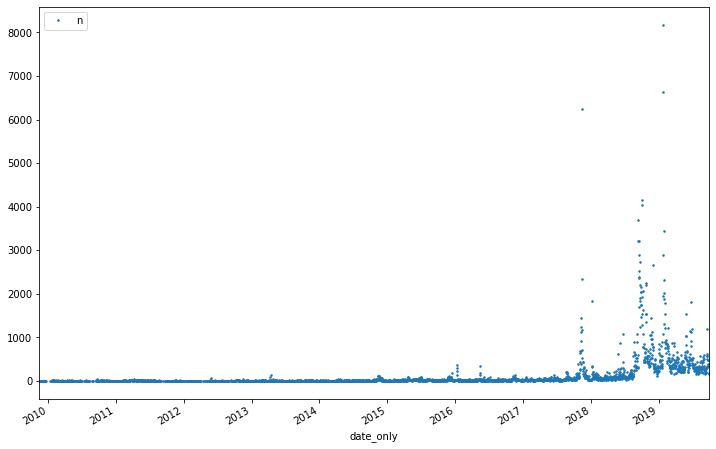

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
df_byday.plot('date_only','n', style=".", ax=ax, ms=3)
plt.show()

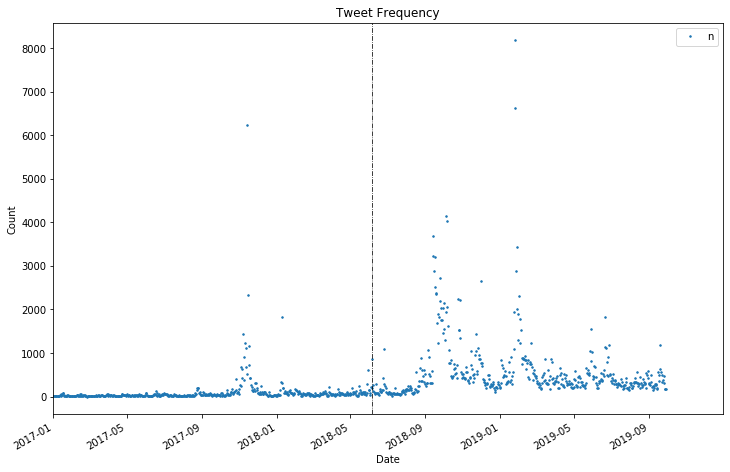

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
df_byday.plot('date_only','n', style=".", ax=ax, ms=3)
ax.set(xlim=(datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')), xlabel="Date",ylabel="Count", title="Tweet Frequency")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.stem('date_only','n', markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')), xlabel="Date",ylabel="Count", title="Tweet Frequency")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.show()

In [35]:
df_byday.sort_values(by='n',ascending=False)[:20]

,date_only,n
2681,2019-01-26,8178
2680,2019-01-25,6621
2243,2017-11-14,6237
2568,2018-10-05,4154
2569,2018-10-06,4032
2546,2018-09-13,3688
2683,2019-01-28,3440
2547,2018-09-14,3217
2549,2018-09-16,3211
2548,2018-09-15,2891


---

### Loading project

In [2]:
p = sm.Project.objects.get(pk=196)

In [17]:
end_date = datetime.datetime.strptime('2019-10-01-+0000', '%Y-%m-%d-%z')

In [66]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project=p)

ttweets = set(tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
).values_list('id',flat=True))

print(len(ttweets))

155559


In [69]:
# get texts
# filter for kohlekommission
texts = tm.Status.objects.filter(
    id__in=ttweets,
    text__contains='#Kohlekommission'
).values_list('text',flat=True)

In [71]:
len(texts)

12168

In [72]:
texts[0]

'.@sigmargabriel: "Wir müssen erst über #Strukturwandel  reden und dann über #Kohleausstieg. Deshalb bin ich gegen die #Kohlekommission ." https://t.co/dy2KlUn0Kd'

In [74]:
taglist = []
regstrip = re.compile('\W\s')
for x in texts:
    match = re.findall('\#.+?\s', x, re.MULTILINE)
    for m in match:
        m1 = regstrip.sub("",m)
        taglist.append(m1.strip().lower())

In [75]:
taglist_df = pd.DataFrame(Counter(taglist).keys(), columns=['Hashtag'])
taglist_df['Count'] = list(Counter(taglist).values())

In [76]:
taglist_df.sort_values(by=['Count'], ascending=False)

,Hashtag,Count
2,#kohlekommission,11380
1,#kohleausstieg,4171
67,#hambacherforst,1253
7,#klimaschutz,871
9,#hambibleibt,839
19,#energiewende,791
2924,#fridaysforfuture,703
11,#endcoal,577
66,#rwe,555
24,#kohle,478


In [6]:
kt = tm.Status.objects.filter(text__icontains="Kohle").values_list('text',flat=True)

In [8]:
# Hashtags for all coal
taglist_kohle = []
regstrip = re.compile('\W\s')
for x in kt:
    match = re.findall('\#.+?\s', x, re.MULTILINE)
    for m in match:
        m1 = regstrip.sub("",m)
        taglist_kohle.append(m1.strip().lower())

In [9]:
taglist_kohle_df = pd.DataFrame(Counter(taglist_kohle).keys(), columns=['Hashtag'])
taglist_kohle_df['Count'] = list(Counter(taglist_kohle).values())

In [11]:
len(taglist_kohle_df)

74409

In [14]:
taglist_kohle_df[taglist_kohle_df.Count > 100].sort_values(by=['Count'], ascending=False)

,Hashtag,Count
89,#kohleausstieg,90903
1,#kohle,43659
118,#kohlekommission,39202
48,#kohlefrei,26700
90,#klimaschutz,20853
115,#hambibleibt,15578
175,#energiewende,15462
114,#hambacherforst,14119
37,#fridaysforfuture,12510
68,#rwe,12453


In [20]:
taglist_kohle_df.to_csv('taglist_kohle.csv')

In [18]:
kk = tm.Status.objects.filter(
    text__icontains="kohlekommission",
    created_at__lte=end_date
)

In [19]:
len(kk)

51691

In [47]:
p1 = sm.Project.objects.get(pk=134)

In [48]:
searches = tm.TwitterSearch.objects.filter(project=p1)

kt1 = tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
).values_list('text',flat=True)

In [49]:
# Hashtags for all coal
taglist_kohle_ts = []
regstrip = re.compile('\W\s')
for x in kt1:
    match = re.findall('\#.+?\s', x, re.MULTILINE)
    for m in match:
        m1 = regstrip.sub("",m)
        taglist_kohle_ts.append(m1.strip().lower())

In [50]:
taglist_kohle_ts_df = pd.DataFrame(Counter(taglist_kohle_ts).keys(), columns=['Hashtag'])
taglist_kohle_ts_df['Count'] = list(Counter(taglist_kohle_ts).values())

In [52]:
taglist_kohle_ts_df[taglist_kohle_ts_df.Count > 100].sort_values(by=['Count'], ascending=False)

,Hashtag,Count
5,#coal,929544
3,#auspol,141064
173,#energy,106013
89,#android,102178
4,#climatechange,92915
70,#climate,86293
81,#solar,70875
40,#news,65579
266,#np,61812
109,#ipad,61316


In [53]:
taglist_kohle_ts_df.to_csv('taglist_kohle_ts_df.csv')